In [171]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import time
import itertools
import glob
import scipy.constants as sc
from math import radians, cos, sin, asin, sqrt


np.set_printoptions(threshold=sys.maxsize)
#%matplotlib notebook

## Import Network Data

In [2]:
df = pd.read_csv('link_reports-20210101-00.csv')

In [3]:
#remove whitespace in dataframe 
cols = df.columns
df[cols] = df[cols].apply(lambda x: x.str.strip() if x.dtype == "object" else x)

In [4]:
data_rate = df[' data_rate_Mbps'].unique().tolist()

## Capacity Calculation Assumptions

Get EIRP based on center frequency 

In [5]:
df_70G = df[df[' band_profile_id'] == '70G-420w']
df_80G = df[df[' band_profile_id'] == '80G-420w']

In [6]:
fc_70 = df_70G[' channel_center_freq_Ghz'].unique().tolist()
fc_80 = df_80G[' channel_center_freq_Ghz'].unique().tolist()

print(fc_70)
print(fc_80)

[71.5, 73.0, 72.25]
[85.5, 84.75, 84.0]


In [7]:
EIRP_70 = df_70G[' effective_isotropic_radiated_power_dbw'].unique().tolist()
EIRP_80 = df_80G[' effective_isotropic_radiated_power_dbw'].unique().tolist()

print(EIRP_70)
print(EIRP_80)

[37.73, 37.72]
[37.16, 37.15, 42.48]


Get transmit powers

In [8]:
Pt_70 = df_70G[' transmit_power_watts'].unique().tolist() #watts
Pt_80 = df_80G[' transmit_power_watts'].unique().tolist() #watts


print(Pt_70)
print(Pt_80)

#corresponds with the Fc vairable

[0.236, 0.229, 0.233]
[0.207, 0.201, 0.103]


In [9]:
#compute possible tx gains -- if similar enough select one value and use 

#EIRP/Tx Gain -- 70

Pt_70 = 10*np.log10(Pt_70) #(dBw)
val1 = np.subtract(EIRP_70[0], Pt_70)
val2 = np.subtract(EIRP_70[1], Pt_70)

Gt_70 = np.concatenate((val1, val2), axis = 0)
print(Gt_70)

Pt_80 = 10*np.log10(Pt_80) #(dBw)
val1 = np.subtract(EIRP_80[0], Pt_80)
val2 = np.subtract(EIRP_80[1], Pt_80)
val3 = np.subtract(EIRP_80[2], Pt_80)

Gt_80 = np.concatenate((val1, val2, val3), axis = 0)
print(Gt_80)

[44.00087997 44.13164518 44.05644079 43.99087997 44.12164518 44.04644079]
[44.00029655 44.12803943 47.03162775 43.99029655 44.11803943 47.02162775
 49.32029655 49.44803943 52.35162775]


Going to assume that transmit/receive gain is ~44dB for all Fc. 

In [10]:
Gt = Gr = 44  #antenna gain, dB

In [11]:
c = sc.physical_constants["speed of light in vacuum"][0] #m/s -- speed of light

In [12]:
#convert GHz -> Hz
fc_70 = np.divide(1, np.multiply(fc_70, 1e9))
fc_80 = np.divide(1, np.multiply(fc_80, 1e9))

#lambda = velocity/frequency 
wavelen_70G = fc_70*c
wavelen_80G = fc_80*c

## Rx Power vs. Data Rate Mapping

#### Define Rx Power (dBw)  to Data Rate Mapping 

##### Mapping for 70 GHz Fc 

[-111.4, -110.1) -> 48Mbps <br>
[-110.1, -107.3) -> 98Mbps <br>
[-107.3, -103.4) -> 195Mbps <br>
[-103.4, -100.9) -> 390Mbps <br>
[-100.9, -95.3) -> 588Mbps <br>
[95.3, -54.95 (Inf)] -> 987Mbps

##### Mapping for 80 GHz Fc

[-108.7, -108.3) -> 48Mbps <br>
[-108.3, -105.3) -> 98Mbps <br>
[-105.3, -101.7) -> 195Mbps <br>
[-101.7, -99.0) -> 390Mbps <br>
[-99.0, -93.7) -> 588Mbps <br>
[-93.7, -56.97 (Inf)] -> 987Mbps

In [13]:
#variables for threshold of rx power (dBw)
min_rx_70_48 = -111.4 
max_rx_70_48 = -110.1

min_rx_70_98 = -110.1
max_rx_70_98 = -107.3

min_rx_70_195 = -107.3
max_rx_70_195 = -103.4

min_rx_70_390 = -103.4
max_rx_70_390 = -100.9

min_rx_70_588 = -100.9
max_rx_70_588 = -95.3

min_rx_70_987 = -95.3

min_rx_80_48 = -108.7
max_rx_80_48 = -108.3

min_rx_80_98 = -108.3
max_rx_80_98 = -105.3

min_rx_80_195 = -105.3
max_rx_80_195 = -101.7

min_rx_80_390 = -101.7
max_rx_80_390 = -99.0

min_rx_80_588 = -99.0
max_rx_80_588 = -95.3

min_rx_80_987 = -95.3

In [14]:
def map_70G(P_rxs): 
    #assign data rate for 70GHz center frequencies 
    c = []
    for P_rx in P_rxs: 
        if P_rx >= min_rx_70_48 and P_rx < max_rx_70_48:
            c.append(48)
        elif P_rx >= min_rx_70_390 and P_rx < max_rx_70_390:
            c.append(390)
        elif P_rx >= min_rx_70_195 and P_rx < max_rx_70_195: 
            c.append(195)
        elif P_rx >= min_rx_70_98 and P_rx < max_rx_70_98:
            c.append(98)
        elif P_rx >= min_rx_70_588 and P_rx < max_rx_70_588: 
            c.append(588)
        elif P_rx >= min_rx_70_987: 
            c.append(987)
        else: 
            c.append(0) #link does not exist
        
    return max(c)

In [15]:
def map_80G(P_rxs): 
    #assign data rate for 80GHz center frequencies 
    c = []
    for P_rx in P_rxs:
        if P_rx >= min_rx_80_48 and P_rx < max_rx_80_48:
            c.append(48)
        elif P_rx >= min_rx_80_390 and P_rx < max_rx_80_390:
            c.append(390)
        elif P_rx >= min_rx_80_195 and P_rx < max_rx_80_195: 
            c.append(195)
        elif P_rx >= min_rx_80_98 and P_rx < max_rx_80_98:
            c.append(98)
        elif P_rx >= min_rx_80_588 and P_rx < max_rx_80_588: 
            c.append(588)
        elif P_rx >= min_rx_80_987: 
            c.append(987)
        else: 
            c.append(0) #link does not exist
    return max(c)

## Capacity Calculation 

For each center frequency and transmit power: 
1) Calculate Rx Power using fspl <br>
2) Assign a data rate to the link/node pair based on the Rx power

$ P_{rx} = P_{tx} + G_{tx} + G_{rx} - L_{fs} $ <br>
$ L_{fs} = 20*log_{10}(4*\pi \frac{d}{\lambda}) $ <br>

distance and wavelength should be in meters<br>
using fspl for now, discuss if other loss forms are necessary <br>

In [16]:
#import distance matrix
dist = np.load('distance_array.npy')

In [17]:
capacity = np.zeros(dist.shape)

In [18]:
#get upper triangle idx
indices = np.triu_indices_from(dist[0])
triu = zip(indices[0], indices[1])
idx_list = list(triu) #convert to list for looping

In [19]:
start_time = time.time()
for t in range(0, dist.shape[0]):
    temp = dist[t]
    
    for idx in range(len(idx_list)):
        row, col = idx_list[idx]
        
        if row!=col:
            d = temp[row][col] #distance
            
            l_fs_70G = 20*np.log10(4*np.pi*(d/wavelen_70G)) #fspl(dB) for each Fc in 70GHz range
            P_rx_70G = np.around(Pt_70-l_fs_70G+Gt+Gr, 2) #receive power (dBw) for each Fc in 70GHz range
            
            l_fs_80G = 20*np.log10(4*np.pi*(d/wavelen_80G)) #fspl(dB) for each Fc in 80GHz range
            P_rx_80G = np.around(Pt_80-l_fs_80G+Gt+Gr, 2) #receive power (dBw) for each Fc in 80GHz range
            
            capacity[t][row][col] = max(map_70G(P_rx_70G), map_80G(P_rx_80G))

        else: 
            capacity[t][row][col] = 0
   
    if t % 2000 == 1999: 
        end_time = time.time()
        print(end_time - start_time)
        
end_time = time.time()
print(end_time - start_time)

35.99224615097046
72.25794768333435
107.75194430351257
143.6533362865448
179.90697860717773
215.17770195007324
252.72909379005432
288.38553261756897
324.4424707889557
361.6877453327179
397.7789499759674
422.08322191238403


In [20]:
capacity = capacity + capacity.transpose(0,2,1)

In [21]:
print(capacity)

[[[  0.   0.   0. ...   0.   0.   0.]
  [  0.   0.   0. ...   0.   0.   0.]
  [  0.   0.   0. ...   0.   0.   0.]
  ...
  [  0.   0.   0. ...   0. 987. 987.]
  [  0.   0.   0. ... 987.   0. 987.]
  [  0.   0.   0. ... 987. 987.   0.]]

 [[  0.   0.   0. ...   0.   0.   0.]
  [  0.   0.   0. ...   0.   0.   0.]
  [  0.   0.   0. ...   0.   0.   0.]
  ...
  [  0.   0.   0. ...   0. 987. 987.]
  [  0.   0.   0. ... 987.   0. 987.]
  [  0.   0.   0. ... 987. 987.   0.]]

 [[  0.   0.   0. ...   0.   0.   0.]
  [  0.   0.   0. ...   0.   0.   0.]
  [  0.   0.   0. ...   0.   0.   0.]
  ...
  [  0.   0.   0. ...   0. 987. 987.]
  [  0.   0.   0. ... 987.   0. 987.]
  [  0.   0.   0. ... 987. 987.   0.]]

 ...

 [[  0.   0.   0. ...   0.   0.   0.]
  [  0.   0.   0. ...   0.   0.   0.]
  [  0.   0.   0. ...   0.   0.   0.]
  ...
  [  0.   0.   0. ...   0.   0.   0.]
  [  0.   0.   0. ...   0.   0. 987.]
  [  0.   0.   0. ...   0. 987.   0.]]

 [[  0.   0.   0. ...   0.   0.   0.]
  [  0.   0.

### Save Variables

In [22]:
np.save('capacity_array.npy', capacity)

Running the next cell is optional -- use it as a checkpoint so you don't have to run everything above this again

In [23]:
capacity = np.load('capacity_array.npy')

## Prune Non-Interesting Links -- Optional

See which flight combinations have predominatantly average zero capacity in time. Further filter all flight combinations, making the optimization problem easier. 

Algorithm explanation: <br> 
1) Get the start and stop indices of the row <br>
2) Get the length of the row <br>
3) Count the number of non-zero elements<br>
4) Repeat step 3 across all time instances and average <br>
5) Repeat 1-4 for all rows <br>

In [24]:
rows = list(range(0, capacity[0].shape[0]-1)) #don't want to index the last row
print(rows)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36]


In [36]:
flt_avgs = []
rows = list(range(0, capacity[0].shape[0]-1)) #don't want to index the last row

for row in rows: 
    #get one row through all time indices 
    temp = capacity[:, row]
    avg_len = float(len(temp[0]))
    
    #filter row since we're working with the upper triangle of the matrix
    temp = temp[:, (row+1):38] #slicing is non-inclusive so the end idx should be incremented by 1 

    #count number of non-zero elements and average for each row
    temp = np.count_nonzero(temp, axis=1)
    temp = np.divide(temp, avg_len)
    
    #round to 3 decimal places
    temp = np.average(temp)
    temp = np.round(temp, 3)

    #average through time
    flt_avgs.append(np.average(temp))

In [37]:
flt_avgs

[0.0,
 0.308,
 0.108,
 0.297,
 0.241,
 0.228,
 0.026,
 0.162,
 0.08,
 0.204,
 0.138,
 0.307,
 0.281,
 0.264,
 0.233,
 0.112,
 0.068,
 0.202,
 0.075,
 0.047,
 0.004,
 0.173,
 0.193,
 0.021,
 0.131,
 0.105,
 0.078,
 0.061,
 0.15,
 0.04,
 0.119,
 0.0,
 0.091,
 0.05,
 0.057,
 0.034,
 0.026]

In [28]:
print(len(flt_avgs))

37


In [29]:
flight_ids = np.load('flight_ids.npy')
print(flight_ids)
print(len(flight_ids))

['LN-128' 'LN-172' 'LN-177' 'LN-179' 'LN-180' 'LN-189' 'LN-190' 'LN-191'
 'LN-192' 'LN-193' 'LN-197' 'LN-201' 'LN-207' 'LN-214' 'LN-215' 'LN-223'
 'LN-248' 'LN-250' 'LN-251' 'LN-263' 'LN-265' 'LN-283' 'LN-284' 'LN-287'
 'LN-289' 'LN-295' 'LN-297' 'LN-298' 'LN-301' 'LN-302' 'LN-305' 'LN-307'
 'LN-309' 'LN-312' 'LN-313' 'LN-318' 'LN-319' 'LN-320']
38


How to interpret the above averages? <br> 

Each row represents a flight. The corresponding row/flight id pair is shown above (ie: index 0 of flt_avgs corresponds to 'LN-128'). I averaged the capacity for each flight and it's corresponding combinations. For example, the first row represents the averaged capacity across time of flight LN-128. It's safe to say that LN-128 is isolated from all other nodes in the network (we can verify with visuals provided by Lakshya). <br> 

But what about other non-zero averages? I take this to mean that the closer the average is to zero (ie: 0.004, 0.026, 0.034, etc) the more isolated this node is from it's neighbors. Therefore, these links are mostly 'uninteresting' to us across the selected date range. <br> 

Therefore, we should keep anything flight with an average greater than or equal to 0.1

In [57]:
num_nodes = 4
flt_avgs_idx= np.sort(np.argsort(flt_avgs)[-num_nodes:])#index of 4 largest nodes to keep
flt_ids_reduced = flight_ids[flt_avgs_idx]

print(flt_avgs_idx)
print(flt_ids_reduced)

[ 1  3 11 12]
['LN-172' 'LN-179' 'LN-201' 'LN-207']


In [63]:
reduced_capacity = capacity[:, flt_avgs_idx, :]
reduced_capacity = reduced_capacity[:, :, flt_avgs_idx]

In [66]:
print(reduced_capacity.shape)
print(reduced_capacity[1000])

(23384, 4, 4)
[[  0.  98. 390. 588.]
 [ 98.   0.  48.  98.]
 [390.  48.   0. 987.]
 [588.  98. 987.   0.]]


In [71]:
np.save('capacity_filtered.npy', reduced_capacity) #save variable
np.save('flt_ids_reduced.npy', flt_ids_reduced)

## Plot Capacity vs. Time

Using reduced capacity for now and corresponding flight ids

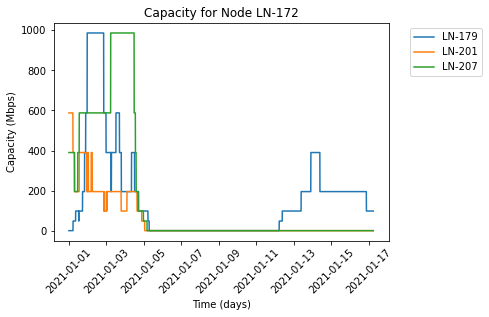

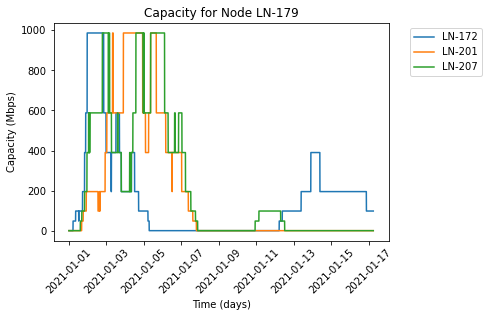

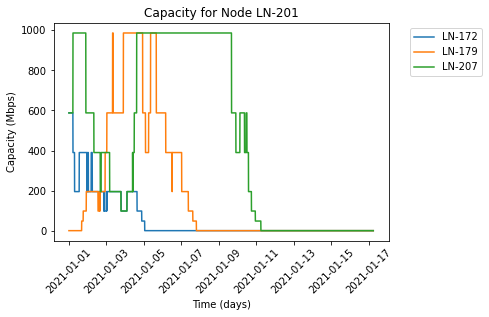

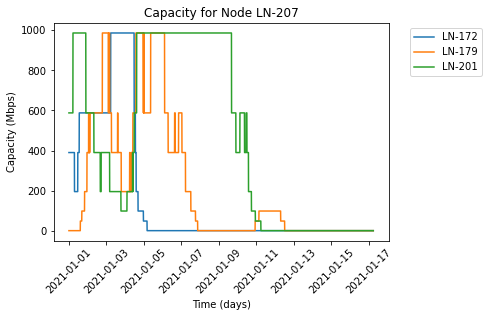

In [70]:
times = np.arange(np.datetime64('2021-01-01'),
                  np.datetime64('2021-01-18'), np.timedelta64(1, 'm'))

times = times[1:reduced_capacity.shape[0]+1]


for row in range(0, reduced_capacity.shape[1]): 
    #figure settings 
    fname = 'Reduced_Capacity Node %s.png' % (flt_ids_reduced[row])
    fig_title = 'Capacity for Node %s' % (flt_ids_reduced[row])
    
    plt.figure()
    plt.xlabel('Time (days)')
    plt.ylabel('Capacity (Mbps)')
    plt.title(fig_title)
    
    #loop through columns and plot 
    temp = reduced_capacity[:, row, :]
    
    
    for column in range(0, reduced_capacity.shape[2]):
        if row!=column:
            plt.plot(times, temp[:, column], label = flt_ids_reduced[column])
        else:
            continue
    
    plt.legend(bbox_to_anchor=(1.05, 1.0), ncol = 1, loc='upper left')
    plt.xticks(rotation=45)
    plt.savefig(fname, dpi = 300, bbox_inches='tight')


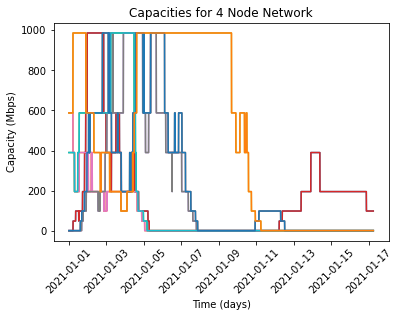

In [91]:
times = np.arange(np.datetime64('2021-01-01'),
                  np.datetime64('2021-01-18'), np.timedelta64(1, 'm'))

times = times[1:reduced_capacity.shape[0]+1]

#figure settings
fname = 'Reduced_Capacity All Node no legend.png' 
fig_title = 'Capacities for 4 Node Network' 

plt.figure()
plt.xlabel('Time (days)')
plt.ylabel('Capacity (Mbps)')
plt.title(fig_title)

for row in range(0, reduced_capacity.shape[1]): 
    #loop through columns and plot 
    temp = reduced_capacity[:, row, :]
    
    for column in range(0, reduced_capacity.shape[2]):
        if row!=column:
            plt.plot(times, temp[:, column], label = label = str(flt_ids_reduced[row]) + ' & ' + str(flt_ids_reduced[column]))
        else:
            continue
    
#plt.legend(bbox_to_anchor=(1.05, 1.0), ncol = 3, loc='upper left')
plt.xticks(rotation=45)
plt.savefig(fname, dpi = 300, bbox_inches='tight')


## Plot Distances for Corresponding Reduced Idx

In [72]:
dist = np.load('distance_array.npy')

In [78]:
dist_reduced = dist[:, flt_avgs_idx, :]
dist_reduced = dist_reduced[:, :, flt_avgs_idx]

np.save('dist_reduced.npy', dist_reduced)

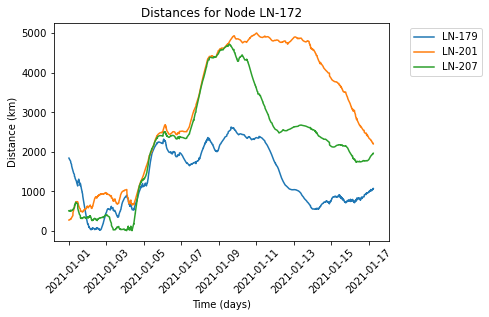

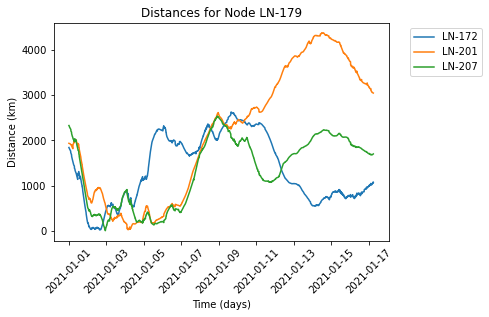

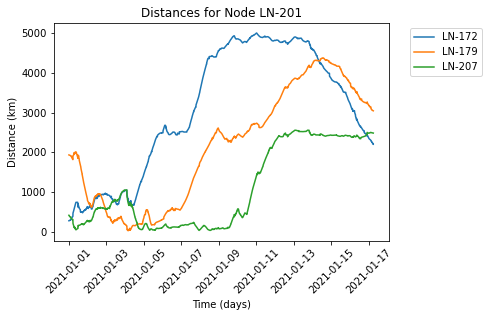

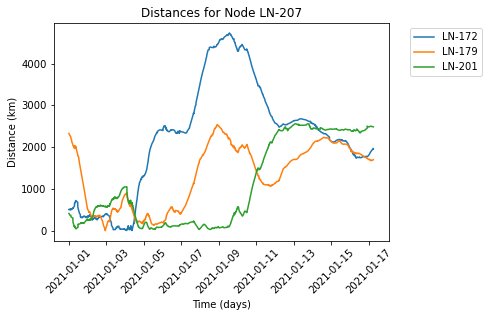

In [84]:
times = np.arange(np.datetime64('2021-01-01'),
                  np.datetime64('2021-01-18'), np.timedelta64(1, 'm'))

times = times[1:dist_reduced.shape[0]+1]

for row in range(0, dist_reduced.shape[1]): 
    #figure settings 
    fname = 'Reduced_Dist Node %s.png' % (flt_ids_reduced[row])
    fig_title = 'Distances for Node %s' % (flt_ids_reduced[row])
    
    fig, ax = plt.subplots()
    ax.set_xlabel('Time (days)')
    ax.set_ylabel('Distance (km)')
    #ax.set_ylim([0, 2000])
    ax.set_title(fig_title)
    
    #loop through columns and plot 
    temp = dist_reduced[:, row, :]

    for column in range(0, dist_reduced.shape[2]):
        #check if on diagonal
        if np.any(temp[:, column]):
            ax.plot(times, temp[:, column]/1e3, label = flt_ids_reduced[column])
        else:
            continue
    
    plt.legend(bbox_to_anchor=(1.05, 1.0), ncol = 1, loc='upper left')
    plt.xticks(rotation=45)
    plt.savefig(fname, dpi = 300, bbox_inches='tight')

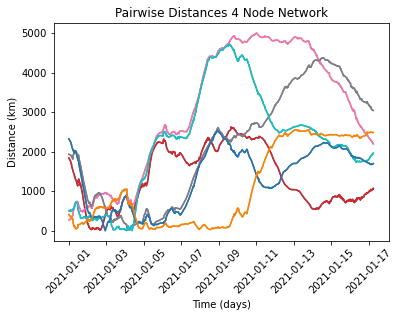

In [90]:
times = np.arange(np.datetime64('2021-01-01'),
                  np.datetime64('2021-01-18'), np.timedelta64(1, 'm'))

times = times[1:dist_reduced.shape[0]+1]



#figure settings 
fname = 'Reduced_Dist Node All no legend' 
fig_title = 'Pairwise Distances 4 Node Network' 

fig, ax = plt.subplots()
ax.set_xlabel('Time (days)')
ax.set_ylabel('Distance (km)')
ax.set_title(fig_title)

for row in range(0, dist_reduced.shape[1]): 
    
    #loop through columns and plot 
    temp = dist_reduced[:, row, :]

    for column in range(0, dist_reduced.shape[2]):
        #check if on diagonal
        if np.any(temp[:, column]):
            ax.plot(times, temp[:, column]/1e3, label = str(flt_ids_reduced[row]) + ' & ' + str(flt_ids_reduced[column]))
        else:
            continue



#plt.legend(bbox_to_anchor=(1.05, 1.0), ncol = 3, loc='upper left')
plt.xticks(rotation=45)
plt.savefig(fname, dpi = 300, bbox_inches='tight')

## Plot Capacity vs. Distance

Scatter plot -- working with a reduced capacity and distance matrix 

In [139]:
x_pts  = [] 
y_pts = []
for i in range(reduced_capacity.shape[0]):
    for row in range(reduced_capacity.shape[1]):
        for j in range(reduced_capacity.shape[2]):
            a = reduced_capacity[i, row, j] #get corresponding capacity
            b = dist_reduced[i, row, j] #get corresponding distance
            if (a!=0.0) & (b!= 0.0): 
                x_pts.append(b/1e3)
                y_pts.append(a)                

In [176]:
#label = ['48.0' if y == 48.0 else '98.0' if y==98.0 else '195.0' if y==195.0 else '390.0' if y==390.0 else '588.0' if y==588.0 else '988.0' if y==988.0 else 'k' for y in y_pts]
c= [0 if y == 48.0 else 1 if y==98.0 else 2 if y==195.0 else 3 if y==390.0 else 4 if y==588.0 else 5 if y==987.0 else 6 for y in y_pts]

<IPython.core.display.Javascript object>


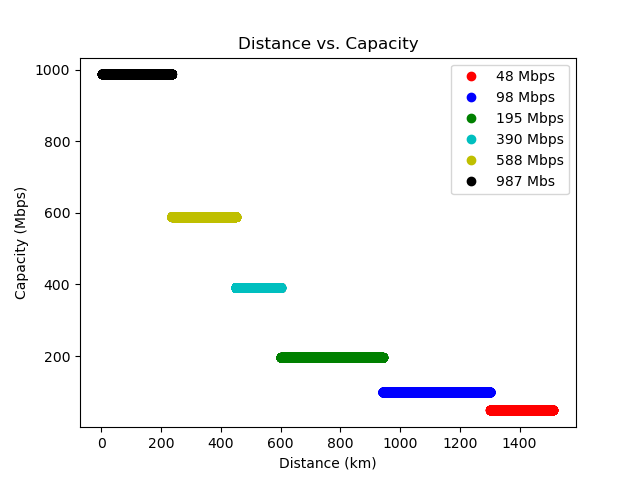

In [179]:
fname = 'distance vs. capacity.png'
fig_title = 'Distance vs. Capacity'

#classes = ['']

plt.figure()
plt.ylabel('Capacity (Mbps)')
plt.xlabel('Distance (km)')
plt.title(fig_title)

colors = ListedColormap(['r','b','g', 'm', 'c', 'y', 'k'])
classes = ['48 Mbps', '98 Mbps', '195 Mbps', '390 Mbps', '588 Mbps', '987 Mbs']
scatter = plt.scatter(x_pts, y_pts, c = c, cmap = colors)
plt.legend(handles=scatter.legend_elements()[0], labels=classes)
plt.savefig(fname, dpi=300, bbox_inches='tight')